<a href="https://colab.research.google.com/github/jjgl0540-hub/Leeds_Energy_Project_GEOG5415M/blob/main/notebooks/GEOG5415M_Final_Project_202018307_03_data_visualisation%20%26%20interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GEOG5415M Final Assignment (Template)

Student ID number:202018307

In [1]:
# read in required packages

# import all packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import geopandas as gpd


In [2]:
# configure plotting settings
%matplotlib inline
sns.set_theme(style="whitegrid")

In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This is an example block of mardown text I want to reference <a href="#ref1">[1]</a>. I might need to add some more citations <a href="#ref2">[2]</a><a href="#ref2">[3]</a>



# **1. Introduction & Data Sources**

This project develops a spatial data analysis workflow to identify variations in energy vulnerability across Leeds. While national energy support policies in the UK are often income-based, they may overlook households that face high energy costs due to poor building efficiency rather than low income alone.

To address this, the project integrates Energy Performance Certificate (EPC) data with selected sociodemographic indicators from the 2021 UK Census.


*   EPC data offers the most detailed energy efficiency records for English residential buildings in terms of building structure, heating systems, and insulation performance—factors that directly determine energy expenditures, aspects that income alone cannot measure.
*   The 2021 census data identifies social groups more vulnerable to energy risks through factors like central heating type, population composition, and income deprivation.



Leeds was selected as the case study because of its diverse housing stock (large-scale Victorian terraced houses) and clearly defined neighbourhood structures, which make it suitable for aggregating EPC records and census indicators at the LSOA level. Local policymakers and energy planners are the target audience for this analysis, as they can leverage this type of spatial evidence to develop more targeted and context-sensitive energy support programs.




**Data Sources:**







*   EPC Data: Sourced from DLUHC (Domestic Energy Performance Certificates), aggregated to LSOA level to represent average housing efficiency.
*   Census 2021: Sourced from NOMIS, providing student population,central heating fuel types and tenure status per LSOA.


*   LSOA Boundaries: Sourced from ONS Geoportal for spatial mapping.





# **2. Programming Workflow & Data preparation**

The programming workflow for this project consists of three stages: data preparation, spatial analysis, and data visualization. This chapter focuses on the data preparation stage, covering the loading, cleaning, aggregation, and integration of multi-source data.



**2.1 Data Loading**


Data comes from various institutions with different file structures and coverage. Common challenges include inconsistent column names, missing shared identifiers, inconsistent coordinate systems, and missing data. To address these issues, we establish a standardized data loading and verification process to ensure the consistency and comparability of the data before analysis.





In [4]:
# load the data
epc=pd.read_csv('/content/drive/MyDrive/Leeds_Energy_Project_GEOG5415M/data/raw/epc_leeds_2025.csv')
imd=pd.read_csv('/content/drive/MyDrive/Leeds_Energy_Project_GEOG5415M/data/raw/imd_2019.csv')
lsoa=gpd.read_file('/content/drive/MyDrive/Leeds_Energy_Project_GEOG5415M/data/raw/LSOA/LSOA_2021_EW_BGC_V5.shp')


/tmp/ipython-input-2001626475.py:2: DtypeWarning: Columns (15,37,39,40,83) have mixed types. Specify dtype option on import or set low_memory=False.
  epc=pd.read_csv('/content/drive/MyDrive/Leeds_Energy_Project_GEOG5415M/data/raw/epc_leeds_2025.csv')


The 2021 census data (from NOMIS) contains multiple rows of metadata headers, and we develop an auxiliary function to uniformly parse all relevant files.

In [5]:
# load remaining data

# NOMIS census files contain metadata in the first few rows
# define a helper function to skip these headers automatically
# consistent parsing across all census datasets.
def read_nomis_csv(path, skiprows=7):
    return pd.read_csv(path, skiprows=skiprows)

# load census attributes using the helper function
heating=read_nomis_csv('/content/drive/MyDrive/Leeds_Energy_Project_GEOG5415M/data/raw/census_heating_2021.csv')
students=read_nomis_csv('/content/drive/MyDrive/Leeds_Energy_Project_GEOG5415M/data/raw/census_students_2021.csv')
tenure=read_nomis_csv('/content/drive/MyDrive/Leeds_Energy_Project_GEOG5415M/data/raw/census_tenure_2021.csv')

**2.2 Spatial Linkage**

In [6]:
# after loading each dataset, basic data integrity checks (such as structure and completeness) were performed.
# this demonstration shows the checks performed on the EPC dataset.

# check the key columns to confirm the existence of energy efficiency rating variables
# required to be aggregated to the LSOA level later.
epc.head()

,LMK_KEY,ADDRESS1,ADDRESS2,ADDRESS3,POSTCODE,BUILDING_REFERENCE_NUMBER,CURRENT_ENERGY_RATING,POTENTIAL_ENERGY_RATING,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,...,CONSTITUENCY_LABEL,POSTTOWN,CONSTRUCTION_AGE_BAND,LODGEMENT_DATETIME,TENURE,FIXED_LIGHTING_OUTLETS_COUNT,LOW_ENERGY_FIXED_LIGHT_COUNT,UPRN,UPRN_SOURCE,REPORT_TYPE
0,001dca82162cbdf798f746f53027c0cc82afda971d5e84...,Flat 2,35a Town Street,Farsley,LS28 5HX,10003805692,E,C,42,70,...,Pudsey,PUDSEY,England and Wales: before 1900,2022-12-06 16:54:30,Rented (private),9.0,NaN,72736113.0,Energy Assessor,100
1,18a413eb393a87aaccdcbbc35d75c519a13bf9713e5d8d...,8 Sackville Street,NaN,NaN,LS7 2AS,10003489215,D,B,61,82,...,Leeds North East,LEEDS,England and Wales: 1900-1929,2022-10-03 15:40:47,Rented (private),12.0,NaN,72658276.0,Energy Assessor,100
2,18ad988b1d1a739e5adfd04531c27c63e7ea810f40c31d...,20 Highfield Gardens,NaN,NaN,LS12 4DU,10003423919,C,B,72,86,...,Leeds West,LEEDS,England and Wales: 2007-2011,2022-10-25 07:49:22,Rented (social),6.0,NaN,72683080.0,Energy Assessor,100
3,18bd4432597b334e2d8031b1ded0e4d713f2133e939b89...,17 Chestnut Gardens,NaN,NaN,LS12 4LP,10002989904,B,A,88,92,...,Leeds West,Leeds,England and Wales: 1983-1990,2022-10-06 16:09:42,Owner-occupied,7.0,NaN,72266470.0,Address Matched,100
4,275687798052018050310193492080467,"9, Foxwood Farm Way",NaN,NaN,LS8 3EE,4759821668,D,B,58,87,...,Leeds East,LEEDS,England and Wales: 1983-1990,2018-05-03 10:19:34,owner-occupied,NaN,NaN,72269527.0,Address Matched,100


A critical issue identified during inspection was the absence of LSOA codes in the raw EPC dataset. To resolve this, this study adopted a postcode-based linkage strategy. A lookup table (ONSPD) was utilized to map individual postcodes to their corresponding LSOA codes.

In [7]:
# since epc dataset does not have an encoding like lsoa_code
# it needs to be converted first
# load the file that converts postcode
lookup=pd.read_csv("/content/drive/MyDrive/Leeds_Energy_Project_GEOG5415M/data/raw/PCD_OA21_LSOA21.csv")

# keep only the necessary fields and use consistent column names
lookup=lookup[["pcds", "lsoa21cd"]].rename(columns={"pcds": "postcode","lsoa21cd": "lsoa_code"})

# clean the postcode (to be consistent with EPC)
lookup["postcode_clean"]=(lookup["postcode"].astype(str).str.upper().str.replace(" ", "", regex=False))

# keep only the two columns needed for the join
lookup=lookup[["postcode_clean", "lsoa_code"]]


/tmp/ipython-input-341271602.py:4: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  lookup=pd.read_csv("/content/drive/MyDrive/Leeds_Energy_Project_GEOG5415M/data/raw/PCD_OA21_LSOA21.csv")


In [8]:
# clean epc postcodes for reliable matching (uppercase + remove spaces)
epc["postcode_clean"]=(epc["POSTCODE"].astype(str).str.upper().str.replace(" ", "", regex=False))

# add lsoa_code to epc dataset
epc=epc.merge(lookup,on="postcode_clean",how="left")

# check the match rate
print(epc['lsoa_code'].notna().mean())

# randomly select several samples
epc[['POSTCODE', 'postcode_clean', 'lsoa_code']].sample(10, random_state=42)

0.9988389184944723


,POSTCODE,postcode_clean,lsoa_code
12561,LS7 2QE,LS72QE,E01011450
26108,LS7 3ER,LS73ER,E01011360
281043,LS28 5LW,LS285LW,E01011593
317456,LS18 4DH,LS184DH,E01011465
4183,LS4 2NG,LS42NG,E01011479
181626,LS12 1DH,LS121DH,E01033015
111460,LS16 7AT,LS167AT,E01011384
396899,LS20 9EY,LS209EY,E01011279
22246,LS10 3SQ,LS103SQ,E01032498
205074,LS3 1BX,LS31BX,E01035045


**2.3 Data Aggregation**

All attribute datasets are spatially joined with the official LSOA boundary file.
As EPC data contains residential-level energy efficiency information, which needs to be aggregated to the LSOA level for spatial comparison with the census data at first. The mean current energy efficiency score is used as the summary indicator, enabling integrated analysis across different spatial scales.

In [9]:
# convert the EPC energy efficiency column to numerical values ​​(for calculating the average)
for c in ["CURRENT_ENERGY_EFFICIENCY", "POTENTIAL_ENERGY_EFFICIENCY"]:
    if c in epc.columns:
        epc[c]=pd.to_numeric(epc[c], errors="coerce")

In [10]:
# re-aggregate and analyze the scores of individual buildings according to LSOA partitions

# aggregate EPC records by LSOA
# remove EPC records without LSOA code
epc_clean=epc.dropna(subset=["lsoa_code"])

# group EPC records by LSOA
epc_grouped=epc_clean.groupby("lsoa_code")

# summarise building-level EPC indicators at the LSOA level to enable spatial comparison
epc_lsoa=epc_grouped.agg(mean_current_eff=("CURRENT_ENERGY_EFFICIENCY", "mean"),mean_potential_eff=("POTENTIAL_ENERGY_EFFICIENCY", "mean"),
    n_properties=("LMK_KEY", "count")).reset_index()

In [11]:
# standardise LSOA identifiers to enable consistent joins across census tables
heating=heating.rename(columns={"mnemonic": "lsoa_code"})
students=students.rename(columns={"mnemonic": "lsoa_code"})
tenure=tenure.rename(columns={"mnemonic": "lsoa_code"})
imd=imd.rename(columns={"LSOA code (2011)": "lsoa_code"})

In [12]:
# combine a census table
lsoa_census=(heating.merge(students, on="lsoa_code", how="left").merge(tenure, on="lsoa_code", how="left").merge(imd, on="lsoa_code", how="left"))

In [13]:
# process LSOA datasets
# uniform key column naming and screen out Leeds' LSOA
lsoa=lsoa.rename(columns={"LSOA21CD": "lsoa_code"})
lsoa_leeds=lsoa[lsoa['lsoa_code'].isin(lsoa_census["lsoa_code"])].copy()

# merge Geometry + Census Attributes + EPC Data
lsoa_geo=(lsoa_leeds.merge(lsoa_census, on="lsoa_code", how="left").merge(epc_lsoa, on="lsoa_code", how="left"))

In [14]:
# check the first few rows to confirm everything is there
lsoa_geo.head(3)

,lsoa_code,LSOA21NM,LSOA21NMW,BNG_E,BNG_N,LAT,LONG,GlobalID,geometry,2021 super output area - lower layer_x,...,Outdoors Sub-domain Rank (where 1 is most deprived),Outdoors Sub-domain Decile (where 1 is most deprived 10% of LSOAs),Total population: mid 2015 (excluding prisoners),Dependent Children aged 0-15: mid 2015 (excluding prisoners),Population aged 16-59: mid 2015 (excluding prisoners),Older population aged 60 and over: mid 2015 (excluding prisoners),Working age population 18-59/64: for use with Employment Deprivation Domain (excluding prisoners),mean_current_eff,mean_potential_eff,n_properties
0,E01011264,Leeds 011A,None,420937,441836,53.8723,-1.68306,64fb7b6a-27ee-4fa8-a1ca-4afde43ea40d,"POLYGON ((421354.761 442327.389, 421423.688 44...",Leeds 011A,...,14415.0,5.0,1252.0,188.0,653.0,411.0,665.0,61.625616,78.948276,406
1,E01011265,Leeds 009A,None,418988,441951,53.8734,-1.71270,fbdef384-ef8d-4255-b68e-6b2aed79304d,"POLYGON ((418598.68 442761.477, 418637.555 442...",Leeds 009A,...,17248.0,6.0,1788.0,321.0,999.0,468.0,1007.0,66.603521,78.628667,1193
2,E01011266,Leeds 008A,None,417489,442615,53.8795,-1.73546,ba94fe93-06c4-4c65-b854-97028172e051,"POLYGON ((418337 441566, 418335.674 441589.328...",Leeds 008A,...,18531.0,6.0,2381.0,483.0,1431.0,467.0,1444.0,66.552332,77.223834,965


In [15]:
lsoa_geo.columns


Index(['lsoa_code', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LONG',
       'GlobalID', 'geometry', '2021 super output area - lower layer_x',
       'Total: All households_x', 'No central heating', 'Mains gas only',
       'Tank or bottled gas only', 'Electric only', 'Oil only', 'Wood only',
       'Solid fuel only', 'Renewable energy only',
       'District or communal heat networks only', 'Other central heating only',
       'Two or more types of central heating (not including renewable energy)',
       'Two or more types of central heating (including renewable energy)',
       '2021 super output area - lower layer_y', 'Total', 'Student',
       'Not a student', '2021 super output area - lower layer',
       'Total: All households_y', 'Owned', 'Shared ownership', 'Social rented',
       'Private rented', 'Lives rent free',
       'Owns with a mortgage or loan or shared ownership',
       'Private rented or lives rent free', 'LSOA name (2011)',
       'Local Authority Distric

After aggregation, the merged files need to be checked to ensure that a unified and comparable spatial unit base is provided for subsequent spatial analysis and visualization.

Number of LSOAs with EPC data: 511
Total number of Leeds LSOAs (geometry): 488


<Axes: >

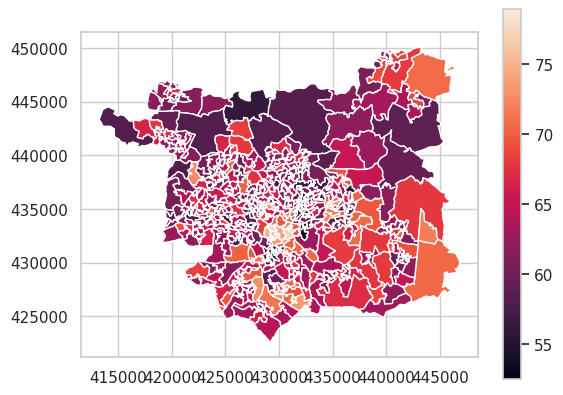

In [16]:
# spatial sanity checks
# coverage check: number of LSOAs represented in each dataset
x_epc_lsoa=epc_lsoa["lsoa_code"].nunique()
x_lsoa_geo=lsoa_geo["lsoa_code"].nunique()

print(f"Number of LSOAs with EPC data: {x_epc_lsoa}")
print(f"Total number of Leeds LSOAs (geometry): {x_lsoa_geo}")

# visual sanity check (should only show Leeds area)
lsoa_geo.plot(column="mean_current_eff", legend=True)

In [17]:
# check missing EPC values after spatial merge
lsoa_geo[["mean_current_eff", "mean_potential_eff", "n_properties"]].isna().sum()


,0
mean_current_eff,0
mean_potential_eff,0
n_properties,0


In [18]:
# check space merging status
lsoa_geo.geometry.is_valid.all()

np.True_

Final checks confirm the dataset is analytically robust, consistently aligned with the 488 Leeds LSOAs, and contains complete records for all study variables.

In [19]:

#lsoa_geo.to_file("/content/drive/MyDrive/Leeds_Energy_Project_GEOG5415/data/lsoa_ready.geojson",driver="GeoJSON")

**2.4 Exploratory check of raw variables**

To better understand the limitations of using a single indicator, an exploratory check was conducted to examine the relationship between income deprivation and housing energy efficiency at the LSOA level. The figure presents a scatter plot of the income deprivation score against mean EPC current efficiency.

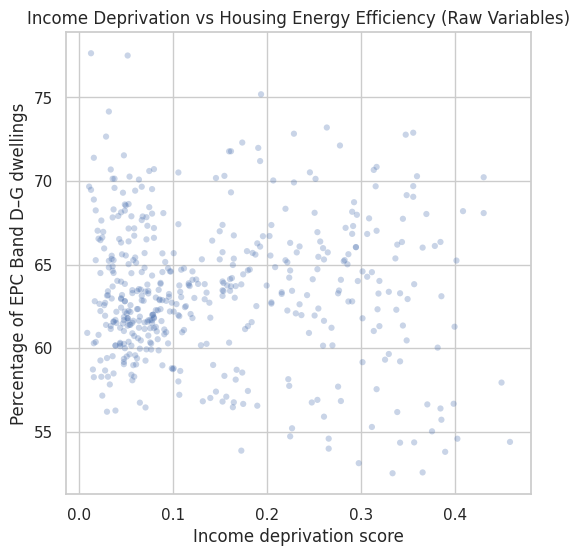

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(
    lsoa_geo["Income Score (rate)"],        # raw income deprivation
    lsoa_geo["mean_current_eff"],               # % EPC Band D–G
    alpha=0.3,
    s=20,
    edgecolors="none"
)

ax.set_xlabel("Income deprivation score")
ax.set_ylabel("Percentage of EPC Band D–G dwellings")
ax.set_title("Income Deprivation vs Housing Energy Efficiency (Raw Variables)")

plt.show()



The scatter shows substantial dispersion and no clear linear relationship, suggesting that income deprivation alone is insufficient to characterise variation in housing energy efficiency across areas.


# **Visualisation & Interpretation**

**3.1 Economic vs physical dimensions of cold-related risk**

Building on the observation that income deprivation alone does not adequately capture variation in housing energy efficiency, this section adopts a multidimensional perspective to examine cold-related vulnerability. This section uses scatter plots of standardized indicators (z-scores) to analyze the joint distribution of economic poverty and housing physical inefficiency at the LSOA level. The zero reference line represents the average situation, thus dividing each region into four quadrants.

For ease of comparison, income poverty and housing energy efficiency are standardized using z-scores, where the energy efficiency values ​​are inverted so that higher values ​​represented greater physical vulnerability.

In [21]:
PHYSICAL_COL = "mean_current_eff"
ECON_COL     = "Income Score (rate)"
LSOA_NAME_COL = "LSOA21NM"

In [22]:
# Prepare a clean GeoDataFrame for analysis
# remove missing geometries
required_cols = [PHYSICAL_COL, ECON_COL, "geometry"]
missing = []
for c in required_cols:
    if c not in lsoa_geo.columns:
        missing.append(c)

if len(missing) > 0:
    raise KeyError(f"Missing columns: {missing}")

# keep only relevant fields
lsoa_risk_gdf = lsoa_geo.copy()
lsoa_risk_gdf = lsoa_risk_gdf[lsoa_risk_gdf.geometry.notnull()].copy()
lsoa_risk_gdf = lsoa_risk_gdf[[LSOA_NAME_COL, PHYSICAL_COL, ECON_COL, "geometry"]].copy()

In [23]:
# standardise indicators for comparability
# energy efficiency is reversed so higher values indicate higher vulnerability
def zscore(s):
    return (s - s.mean()) / s.std()

# standardise variables so they are comparable
lsoa_risk_gdf["phys_poverty_z"] = zscore(-lsoa_risk_gdf[PHYSICAL_COL])
lsoa_risk_gdf["econ_poverty_z"] = zscore(lsoa_risk_gdf[ECON_COL])

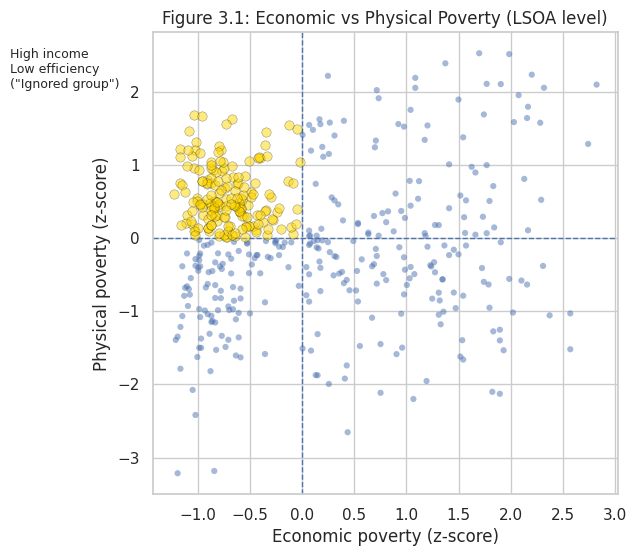

In [24]:
fig, ax = plt.subplots(figsize=(6, 6))

# define ignored group (upper-left quadrant)
ignored = lsoa_risk_gdf[(lsoa_risk_gdf["econ_poverty_z"] < 0) & (lsoa_risk_gdf["phys_poverty_z"] > 0)]

# background points = everything except ignored
rest = lsoa_risk_gdf[~((lsoa_risk_gdf["econ_poverty_z"] < 0) & (lsoa_risk_gdf["phys_poverty_z"] > 0))]

# plot background
ax.scatter(rest["econ_poverty_z"], rest["phys_poverty_z"],alpha=0.5, s=20,edgecolors="none", linewidths=0,zorder=1)

# reference lines at mean (z=0)
ax.axhline(0, linestyle="--", linewidth=1)
ax.axvline(0, linestyle="--", linewidth=1)

# plot highlighted group
ax.scatter(ignored["econ_poverty_z"], ignored["phys_poverty_z"],color="gold", alpha=0.5, s=45,edgecolors="black", linewidths=0.3,zorder=3)

ax.set_xlabel("Economic poverty (z-score)")
ax.set_ylabel("Physical poverty (z-score)")
ax.set_title("Figure 3.1: Economic vs Physical Poverty (LSOA level)")

ax.text(-2.8, 2.6, "High income\nLow efficiency\n(\"Ignored group\")", fontsize=9, ha="left", va="top")

plt.show()

The figure reveals that economic and physical poverty are only weakly correlated overall. Notably, a distinct cluster of LSOAs appears in the upper-left quadrant, characterised by relatively high income levels but poor housing energy efficiency. These areas would be overlooked by income-based targeting alone, motivating the construction of a composite cold risk index that captures overlapping vulnerabilities more effectively.

**3.2 Construction of the Cold Index**

The Cold Index is defined as the arithmetic mean of standardized economic and physical vulnerability indicators, with each dimension weighted equally. The formula reflects the combined impact of income constraints and housing conditions on cold-related risks and is consistent with the UK's definition of fuel poverty under the Low Income Low Energy Efficiency (LILEE) framework.

In [25]:
# combine physical and economic poverty into a single index
lsoa_risk_gdf["cold_index"] = (lsoa_risk_gdf["phys_poverty_z"] + lsoa_risk_gdf["econ_poverty_z"]) / 2

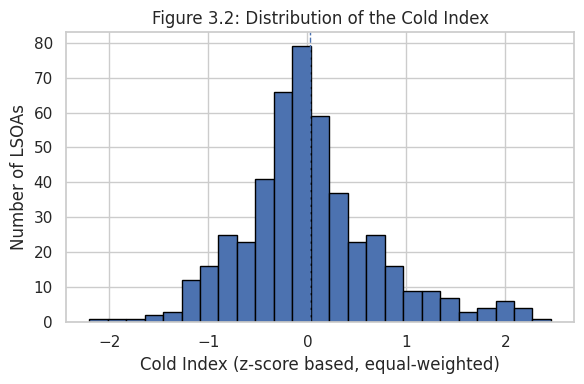

In [26]:
import matplotlib.pyplot as plt

# --- Figure 3.2: Distribution of the Cold Index (Histogram) ---
fig, ax = plt.subplots(figsize=(6, 4))

# drop missing values to avoid plotting issues
x = lsoa_risk_gdf["cold_index"].dropna()

ax.hist(x, bins=25, edgecolor="black")
ax.axvline(x.mean(), linestyle="--", linewidth=1)

ax.set_title("Figure 3.2: Distribution of the Cold Index")
ax.set_xlabel("Cold Index (z-score based, equal-weighted)")
ax.set_ylabel("Number of LSOAs")

plt.tight_layout()
plt.show()


The figure presents the distribution of the Cold Index across LSOAs, showing meaningful variation prior to spatial analysis in Section 3.3.

**3.3 Spatial patterns of cold-related vulnerability**

Building upon the coldness index, this section explores the spatial distribution of cold-related vulnerabilities in Greater London. First, a bivariate hierarchical statistical map is used to investigate the combined spatial structure of economic and material poverty, highlighting different vulnerability combinations at the Small Local Area of ​​Occupation (LSOA) level. This descriptive mapping focuses on the structure and composition of risk rather than statistical significance. Subsequently, the Local Moran's I index is applied to the coldness index to assess whether there is significant spatial clustering of overall cold-related vulnerabilities.

**3.3.1 Static Map: Bivariate Choropleth**

While the Cold Index provides a continuous overview of joint vulnerability, this section employs bivariate contour plots to decompose its underlying dimensions and reveal the spatial distribution of different combinations of economic and physical poverty. Both indices are divided into three quantile-based groups (k = 3) to ensure balanced sample sizes across groups while avoiding excessive dispersion.

In [27]:
econ_var = ECON_COL

# higher EPC efficiency = lower vulnerability
#　use -eff to make higher values = higher physical poverty
lsoa_risk_gdf["physical_poverty"] = -lsoa_risk_gdf[PHYSICAL_COL]
phys_var = "physical_poverty"

In [28]:
# set the bivariate class resolution —— 3x3
# k = 3 divides each dimension into low / medium / high groups
# avoiding over-fragmentation
k = 3

# create quantile-based classes for each variable
# pd.qcut splits data into k quantiles (roughly equal counts)
# labels=False returns 0..(k-1); +1 converts them to 1..k
# duplicates="drop" avoids errors when tied values cause non-unique bin edges

lsoa_risk_gdf["ECON_q"] = ( pd.qcut(lsoa_risk_gdf[econ_var], q=k, labels=False, duplicates="drop") + 1)
lsoa_risk_gdf["PHYSICAL_q"] = (pd.qcut(lsoa_risk_gdf[phys_var], q=k, labels=False, duplicates="drop") + 1)

In [29]:
# ensure class columns keep missing values properly
# using pandas "Int64" (capital I) keeps NA as <NA> instead of converting to float
lsoa_risk_gdf["ECON_q"] = lsoa_risk_gdf["ECON_q"].astype("Int64")
lsoa_risk_gdf["PHYSICAL_q"] = lsoa_risk_gdf["PHYSICAL_q"].astype("Int64")


In [30]:
# build bivariate code + define three headline risk types
# bivariate class code:
#   econ is the row (1..k), physical is the column (1..k)
#   results in 1..k^2 (e.g., for k=3 -> 1..9)
lsoa_risk_gdf["bi_class"] = (lsoa_risk_gdf["ECON_q"] - 1) * k + lsoa_risk_gdf["PHYSICAL_q"]

# define headline risk types
# assumption: higher quantile = worse
# only three extreme combinations are explicitly labelled for interpretation;
# remaining combinations are grouped as "Other".
lsoa_risk_gdf["risk_type"] = "Other"
lsoa_risk_gdf.loc[(lsoa_risk_gdf["ECON_q"] == k) & (lsoa_risk_gdf["PHYSICAL_q"] == k),"risk_type"] = "A: double poverty"
lsoa_risk_gdf.loc[(lsoa_risk_gdf["ECON_q"] == 1) & (lsoa_risk_gdf["PHYSICAL_q"] == k),"risk_type"] = "B: physical only"
lsoa_risk_gdf.loc[(lsoa_risk_gdf["ECON_q"] == k) & (lsoa_risk_gdf["PHYSICAL_q"] == 1), "risk_type"] = "C: economic only"


In [31]:
# setup an manual matrices to avoid extra dependencies
# rows: economic poverty (low=1 -> high=k)
# cols: physical poverty (low=1 -> high=k)
palette = [ ["#e8e8e8", "#ace4e4", "#5ac8c8"],
        ["#dfb0d6", "#a5add3", "#5698b9"],
        ["#be64ac", "#8c62aa", "#3b4994"],]

In [32]:
# map (ECON_q, PHYSICAL_q) to a colour for each LSOA
# missing class values are assigned a neutral grey for plotting
na_color = "#d9d9d9"

def pick_colour(row):
    econ_q = row["ECON_q"]
    phys_q = row["PHYSICAL_q"]

    # if either dimension is missing, use the NA colour
    if pd.isna(econ_q) or pd.isna(phys_q):
        return na_color

    # convert class labels (1..k) to list indices (0..k-1) and pick colour
    return palette[int(econ_q) - 1][int(phys_q) - 1]

# apply the colour assignment row by row
lsoa_risk_gdf["bi_color"] = lsoa_risk_gdf.apply(pick_colour, axis=1)

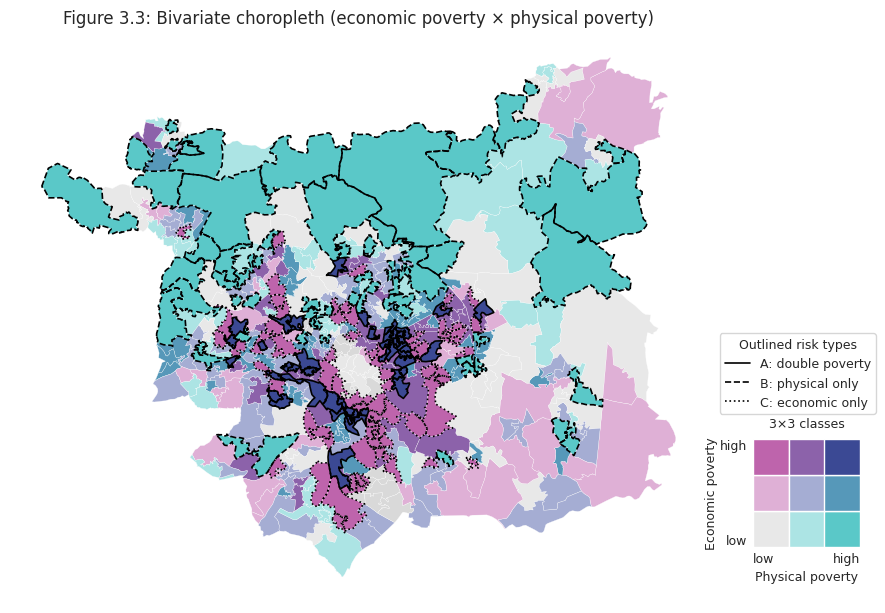

In [33]:
# create bivariate choropleth
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

lsoa_risk_gdf.plot(ax=ax,color=lsoa_risk_gdf["bi_color"], edgecolor="white",linewidth=0.2)

ax.set_title("Figure 3.3: Bivariate choropleth (economic poverty × physical poverty)", fontsize=12)
ax.set_axis_off()

# highlight three headline risk types (outline only)
# A: solid, B: dashed, C: dotted
lsoa_risk_gdf.loc[lsoa_risk_gdf["risk_type"].str.startswith("A")].plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1.2)
lsoa_risk_gdf.loc[lsoa_risk_gdf["risk_type"].str.startswith("B")].plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1.2, linestyle="--")
lsoa_risk_gdf.loc[lsoa_risk_gdf["risk_type"].str.startswith("C")].plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1.2, linestyle=":")

# add outline legend
outline_handles = [plt.Line2D([0], [0], color="black", lw=1.2, linestyle="-",  label="A: double poverty"),
    plt.Line2D([0], [0], color="black", lw=1.2, linestyle="--", label="B: physical only"),
    plt.Line2D([0], [0], color="black", lw=1.2, linestyle=":",  label="C: economic only"),]
ax.legend(handles=outline_handles,title="Outlined risk types",loc="lower right",bbox_to_anchor=(1.25, 0.32), frameon=True,fontsize=9,title_fontsize=9)

# turn off axes and draw the legend grid manually to avoid stray ticks/lines
# add a k×k bivariate legend (clean, no axis lines)
# move right + slightly smaller
legend_ax = fig.add_axes([0.95, 0.24, 0.12, 0.12])
legend_ax.set_xlim(0, k)
legend_ax.set_ylim(0, k)
# turn off all ticks/lines/frames
legend_ax.axis("off")

# draw legend squares
for econ_row in range(k):
    for phys_col in range(k):
        legend_ax.add_patch(plt.Rectangle((phys_col, econ_row), 1, 1,facecolor=palette[econ_row][phys_col],edgecolor="white"))

# add simple labels (placed just outside the grid)
legend_ax.text(k/2, -0.65, "Physical poverty", ha="center", va="top", fontsize=9)
legend_ax.text(-0.95, k/2, "Economic poverty", ha="right", va="center", rotation=90, fontsize=9)

legend_ax.text(0, -0.15, "low", ha="left", va="top", fontsize=9)
legend_ax.text(k, -0.15, "high", ha="right", va="top", fontsize=9)
legend_ax.text(-0.15, 0, "low", ha="right", va="bottom", fontsize=9)
legend_ax.text(-0.15, k, "high", ha="right", va="top", fontsize=9)

legend_ax.text(k/2, k + 0.25, f"{k}×{k} classes", ha="center", va="bottom", fontsize=9)

plt.show()

This bivariate contour map, by jointly classifying the basic statistical areas (LSOAs) of Greater London along both economic and physical poverty dimensions, reveals significant spatial heterogeneity in poverty across the region. Areas facing both high economic and physical poverty (“double poverty”) are spatially concentrated primarily in central and eastern London. This result indicates that poverty in London exhibits a diverse spatial pattern, rather than a single, homogeneous distribution.

This map is primarily intended for policymakers and planners. By clearly distinguishing between areas of double poverty and those affected by only one dimension of poverty, it helps them quickly identify different types of vulnerable areas, thereby supporting the determination of intervention priorities and the development of differentiated policy measures.

**3.3.2 Interactive Map: Local Moran’s I clusters (and tooltips)**

This section uses Local Moran's I (LSOA) analysis to analyze the composite risk score and identify statistically significant local poverty clusters. Queen adjacency spatial weights are used, and row standardization is applied, marking only clusters with p < 0.05; insignificant areas are retained for contextual reference.


In [34]:
# spatial weights and local spatial autocorrelation
from libpysal.weights import Queen
from esda.moran import Moran_Local

# interactive mapping
import folium

In [35]:
from libpysal.weights import Queen
from esda.moran import Moran_Local

# keep lsoas with valid risk scores for lisa
lsoa_lisa_gdf = lsoa_risk_gdf.dropna(subset=["cold_index"]).copy()

# build queen contiguity weights and row-standardise
queen_weights = Queen.from_dataframe(lsoa_lisa_gdf)
queen_weights.transform = "r"

# run local moran's i and store quadrant + p-value
lisa_results = Moran_Local(lsoa_lisa_gdf["cold_index"].values, queen_weights, permutations=999)
lsoa_lisa_gdf["lisa_q"] = lisa_results.q
lsoa_lisa_gdf["lisa_p"] = lisa_results.p_sim


# local moran’s i identifies spatial clustering of the risk score
# using queen contiguity weights (row-standardised);
# clusters are labelled only when p < 0.05, otherwise areas are treated as not significant
alpha = 0.05
lsoa_lisa_gdf["lisa_label"] = "Not significant"
sig_mask = lsoa_lisa_gdf["lisa_p"] < alpha

# assign labels for significant lisa clusters (1=hh, 2=lh, 3=ll, 4=hl)
lsoa_lisa_gdf.loc[sig_mask & (lsoa_lisa_gdf["lisa_q"] == 1), "lisa_label"] = "HH"
lsoa_lisa_gdf.loc[sig_mask & (lsoa_lisa_gdf["lisa_q"] == 2), "lisa_label"] = "LH"
lsoa_lisa_gdf.loc[sig_mask & (lsoa_lisa_gdf["lisa_q"] == 3), "lisa_label"] = "LL"
lsoa_lisa_gdf.loc[sig_mask & (lsoa_lisa_gdf["lisa_q"] == 4), "lisa_label"] = "HL"

# quick checks
print(lsoa_lisa_gdf["lisa_label"].value_counts(dropna=False))
print((lsoa_lisa_gdf["lisa_p"] < alpha).mean())


/tmp/ipython-input-1051412475.py:8: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  queen_weights = Queen.from_dataframe(lsoa_lisa_gdf)


lisa_label
Not significant    346
LL                  60
HH                  56
HL                   8
LH                   3
Name: count, dtype: int64
0.26849894291754756


In [36]:
# interactive map to explore local moran's i clusters
# tooltips allow querying cluster label, p-value and component metrics for each lsoa
import folium

# compute centroid in a projected crs (epsg:27700), then convert to epsg:4326 for folium
cent_27700 = lsoa_lisa_gdf.to_crs(epsg=27700).geometry.centroid
cent_4326 = gpd.GeoSeries(cent_27700, crs=27700).to_crs(epsg=4326)

# colour mapping for lisa cluster labels
cluster_colors = {"HH": "#d7191c", "LL": "#2c7bb6","HL": "#fdae61","LH": "#abd9e9","Not significant": "lightgrey"}

# fields shown when hovering over an lsoa
TOOLTIP_FIELDS = ["lisa_label", "lisa_p", "cold_index", "Income Score (rate)", "mean_current_eff"]
TOOLTIP_ALIASES = [f"{c}:" for c in TOOLTIP_FIELDS]

# create the interactive basemap
lisa_map = folium.Map(location=[cent_4326.y.mean(), cent_4326.x.mean()],zoom_start=9,tiles="CartoDB positron")

# style each polygon based on its lisa label
def style_func(feat):
    label = feat["properties"].get("lisa_label", "Not significant")
    col = cluster_colors.get(label, "lightgrey")
    return {"fillColor": col, "color": "white", "weight": 0.3, "fillOpacity": 0.9}

# hover tooltip configuration
tooltip = folium.GeoJsonTooltip(fields=TOOLTIP_FIELDS,aliases=TOOLTIP_ALIASES,localize=True,sticky=False)

# add lisa polygons to the folium map
folium.GeoJson(lsoa_lisa_gdf,name="local moran's i (p<0.05)",style_function=style_func,tooltip=tooltip).add_to(lisa_map)

# layer toggle
folium.LayerControl().add_to(lisa_map)

lisa_map


An interactive map visualizes different cluster types. Hovering tooltips allow users to view detailed information for each LSOA, including cluster category, significance level, and relevant indicators constituting the composite risk index.

This interactive LISA map is primarily aimed at local government analysts and researchers, providing statistically robust community-scale evidence to identify areas with significant risk clustering and to explain the potential drivers of their spatial clustering, thereby supporting evidence-based target setting and monitoring.

In [37]:
# quick check: why some lsoas are excluded from lisa
econ_raw = "Income Score (rate)"

print("total lsoas:", len(lsoa_risk_gdf))
print("missing income score:", lsoa_risk_gdf[econ_raw].isna().sum())
print("missing cold_index:", lsoa_risk_gdf["cold_index"].isna().sum())


total lsoas: 488
missing income score: 15
missing cold_index: 15


A few regions (LSOAs) lack income scores, which makes it impossible to calculate the composite risk score; these regions are excluded from the LISA analysis and are therefore shown as unclassified on the map.

**Limitations & Ethical Considerations**

**4.1 Methodological Simplification in Index Construction**

**4.2 Data Coverage Bias in EPC Records**

**4.3 Spatial Aggregation and the MAUP**

**4.4 Temporal Misalignment and Energy Price Dynamics**

**Conclusion**

**5.1 Summary of Key Findings**

**5.2 Targeted Policy Implications by Area Type**

**5.3 Implications for Energy Justice and Urban Policy**

**5.4 Directions for Future Research**

Data Visualisation
- Don't forget to present your final two data visualisation (one spatial and one non-spatial) and the justifications about the decisions you made whilst preparing and visualising the data.

## References
<p><a href="add_url_here">[1]</a>Footnote citation goes here</p>
<p><a href="https://github.com/FrancescaPontin/GEOG5415M-Programming-for-Spatial-Data-Science">[2]</a>GEOG5415M course materials</p>
<p><a href="add_url_here">[3]</a>Citation 3</p>